In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np 
import scipy.stats as stats
from numba import jit
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math
from nelson_siegel_svensson.calibrate import calibrate_ns_ols 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [57]:
# Define file paths for GDP and CPI data
files = {
    "Eurozone": {
        "GDP": "../Data CSV/GDP Real USD Eurozone Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y Eurozone Monthly Economic Time Series Profile.xls",
    },
    "Switzerland": {
        "GDP": "../Data CSV/GDP Real USD Switzerland Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y Switzerland Monthly Economic Time Series Profile.xls",
    },
    "USA": {
        "GDP": "../Data CSV/GDP Real USD United States of America Quarterly Economic Time Series Profile.xls",
        "CPI": "../Data CSV/CPI Y o Y United States of America Monthly Economic Time Series Profile.xls",
    },
}

store = {}
for country, paths in files.items():
    print(country)

    # Read GDP and CPI data
    gdp_df = pd.read_excel(paths["GDP"], sheet_name="Series Values", header=6)
    cpi_df = pd.read_excel(paths["CPI"], sheet_name="Series Values", header=6)

    # Ensure 'Period' is in datetime format
    gdp_df['Period'] = pd.to_datetime(gdp_df['Period'], errors='coerce')
    cpi_df['Period'] = pd.to_datetime(cpi_df['Period'], errors='coerce')

    # Select relevant columns
    gdp_df = gdp_df[['Period', 'Y-o-Y Change %']].rename(columns={'Y-o-Y Change %': 'GDP_YoY%'})
    cpi_df = cpi_df[["Period", "Value"]].rename(columns={'Value': 'CPI_YoY%'})

    # Define the date range as pandas Timestamps
    start_date = pd.Timestamp("2000-03-31")
    end_date = pd.Timestamp("2024-08-31")

    # Filter dataframes within the date range
    gdp_df = gdp_df[(gdp_df['Period'] >= start_date) & (gdp_df['Period'] <= end_date)]
    cpi_df = cpi_df[(cpi_df['Period'] >= start_date) & (cpi_df['Period'] <= end_date)]

    print("GDP DATA FOR " + country)
    print(gdp_df)
    print("CPI DATA FOR " + country)
    print(cpi_df)

    # Merge GDP and CPI data
    store[country] = pd.merge(gdp_df, cpi_df, on='Period', how='outer')

    print(store[country])


Eurozone
GDP DATA FOR Eurozone
       Period GDP_YoY%
1  2024-06-30    0.006
2  2024-03-31   0.0046
3  2023-12-31   0.0063
4  2023-09-30   0.0047
5  2023-06-30   0.0103
..        ...      ...
94 2001-03-31   0.0512
95 2000-12-31   0.0333
96 2000-09-30   0.0392
97 2000-06-30   0.0467
98 2000-03-31   0.0426

[98 rows x 2 columns]
CPI DATA FOR Eurozone
        Period  CPI_YoY%
2   2024-08-31      2.17
3   2024-07-31      2.58
4   2024-06-30      2.52
5   2024-05-31      2.57
6   2024-04-30      2.37
..         ...       ...
291 2000-07-31      2.09
292 2000-06-30      2.14
293 2000-05-31      1.76
294 2000-04-30      1.71
295 2000-03-31      1.96

[294 rows x 2 columns]
        Period GDP_YoY%  CPI_YoY%
0   2000-03-31   0.0426      1.96
1   2000-04-30      NaN      1.71
2   2000-05-31      NaN      1.76
3   2000-06-30   0.0467      2.14
4   2000-07-31      NaN      2.09
..         ...      ...       ...
289 2024-04-30      NaN      2.37
290 2024-05-31      NaN      2.57
291 2024-06-30    

In [58]:
store["USA"]['GDP_YoY%'] = store["USA"]['GDP_YoY%']\
    .str.replace('%', '', regex=False)\
    .str.replace(r'\((.*?)\)', r'-\1', regex=True)\
    .astype(float) / 100


# %%
store["USA"]['GDP_YoY%'] = store["USA"]['GDP_YoY%'].ffill()
store["Eurozone"]['GDP_YoY%'] = store["Eurozone"]['GDP_YoY%'].ffill()
store["Switzerland"]['GDP_YoY%'] = store["Switzerland"]['GDP_YoY%'].ffill()

print(store["Eurozone"])
print(store["USA"])
print(store["Switzerland"])



        Period  GDP_YoY%  CPI_YoY%
0   2000-03-31    0.0426      1.96
1   2000-04-30    0.0426      1.71
2   2000-05-31    0.0426      1.76
3   2000-06-30    0.0467      2.14
4   2000-07-31    0.0467      2.09
..         ...       ...       ...
289 2024-04-30    0.0046      2.37
290 2024-05-31    0.0046      2.57
291 2024-06-30    0.0060      2.52
292 2024-07-31    0.0060      2.58
293 2024-08-31    0.0060      2.17

[294 rows x 3 columns]
        Period  GDP_YoY%  CPI_YoY%
0   2000-03-31    0.0422      3.76
1   2000-04-30    0.0422      3.07
2   2000-05-31    0.0422      3.19
3   2000-06-30    0.0524      3.73
4   2000-07-31    0.0524      3.66
..         ...       ...       ...
289 2024-04-30    0.0290      3.36
290 2024-05-31    0.0290      3.27
291 2024-06-30    0.0304      2.97
292 2024-07-31    0.0304      2.89
293 2024-08-31    0.0304      2.53

[294 rows x 3 columns]
        Period  GDP_YoY%  CPI_YoY%
0   2000-03-31    0.0432      1.48
1   2000-04-30    0.0432      1.40
2   200

/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_43042/3099395196.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  store["Eurozone"]['GDP_YoY%'] = store["Eurozone"]['GDP_YoY%'].ffill()
/var/folders/29/j6zpgq394917k8prm4sg190h0000gn/T/ipykernel_43042/3099395196.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  store["Switzerland"]['GDP_YoY%'] = store["Switzerland"]['GDP_YoY%'].ffill()


In [59]:

# Step 1: Fit MRS Model to Inflation Data FOR THE EUROZONE
# Fit a two-regime Markov Switching model to the inflation rate
# Inflation Model
inflation_model = MarkovRegression(store["Eurozone"]['CPI_YoY%'], k_regimes=2, trend='c', switching_variance=True)
inflation_result = inflation_model.fit()

print("Inflation Model Summary:")
print(inflation_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Eurozone"]['Low_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[0]
store["Eurozone"]['High_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Eurozone"]['Inflation_Regime'] = np.where( store["Eurozone"]['Low_Inf_Prob'] > store["Eurozone"]['High_Inf_Prob'], 1, 2)


Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -509.757
Date:                Sat, 09 Nov 2024   AIC                           1031.515
Time:                        19:04:35   BIC                           1053.616
Sample:                             0   HQIC                          1040.366
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4501      0.108      4.185      0.000       0.239       0.661
sigma2         0.2712      

In [60]:
# store["Eurozone"]["Inflation_Regime"].value_counts()

filtered_rows = store["Eurozone"][store["Eurozone"]['Inflation_Regime'] == 1]

print(filtered_rows.head(60))


        Period  GDP_YoY%  CPI_YoY%  Low_Inf_Prob  High_Inf_Prob  \
106 2009-01-31   -0.0185      1.13      0.643967       0.356033   
107 2009-02-28   -0.0185      1.18      0.860413       0.139587   
108 2009-03-31   -0.0499      0.57      0.979431       0.020569   
109 2009-04-30   -0.0499      0.61      0.996798       0.003202   
110 2009-05-31   -0.0499      0.04      0.999472       0.000528   
111 2009-06-30   -0.0454     -0.14      0.999765       0.000235   
112 2009-07-31   -0.0454     -0.64      0.999613       0.000387   
113 2009-08-31   -0.0454     -0.16      0.999814       0.000186   
114 2009-09-30   -0.0365     -0.33      0.999774       0.000226   
115 2009-10-31   -0.0365     -0.13      0.999624       0.000376   
116 2009-11-30   -0.0365      0.48      0.998322       0.001678   
117 2009-12-31   -0.0148      0.93      0.988420       0.011580   
118 2010-01-31   -0.0148      0.95      0.952707       0.047293   
119 2010-02-28   -0.0148      0.85      0.828552       0.17144

In [61]:
# Step 2: Fit MRS Model to GDP Data FOR THE EUROZONE
# Fit a two-regime Markov Switching model to the GDP rate
# GDP Model
growth_model = MarkovRegression(store["Eurozone"]['GDP_YoY%'], k_regimes=2, trend='c', switching_variance=True)
growth_result = growth_model.fit()

print("Growth Model Summary:")
print(growth_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Eurozone"]['Low_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[0]
store["Eurozone"]['High_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Eurozone"]['Growth_Regime'] = np.where( store["Eurozone"]['Low_Growth_Prob'] > store["Eurozone"]['High_Growth_Prob'], 1, 2)


Growth Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               GDP_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                 792.730
Date:                Sat, 09 Nov 2024   AIC                          -1573.461
Time:                        19:04:41   BIC                          -1551.359
Sample:                             0   HQIC                         -1564.610
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0176      0.001     19.915      0.000       0.016       0.019
sigma2      6.262e-05   1.14e-

In [62]:
# For CPI Data
print("Inflation Model Summary:")
print(inflation_result.summary())

# For GDP Data
print("Growth Model Summary:")
print(growth_result.summary())

Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -509.757
Date:                Sat, 09 Nov 2024   AIC                           1031.515
Time:                        19:05:03   BIC                           1053.616
Sample:                             0   HQIC                          1040.366
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4501      0.108      4.185      0.000       0.239       0.661
sigma2         0.2712      

In [ ]:
# Extract smoothed probabilities
inflation_smoothed_probs = inflation_result.smoothed_marginal_probabilities
growth_smoothed_probs = growth_result.smoothed_marginal_probabilities

# Add to DataFrame
store["Eurozone"]['Inflation_Regime_Prob_0'] = inflation_smoothed_probs[0]
store["Eurozone"]['Inflation_Regime_Prob_1'] = inflation_smoothed_probs[1]

store["Eurozone"]['Growth_Regime_Prob_0'] = growth_smoothed_probs[0]
store["Eurozone"]['Growth_Regime_Prob_1'] = growth_smoothed_probs[1]

In [64]:
store["Eurozone"]

,Period,GDP_YoY%,CPI_YoY%,Low_Inf_Prob,High_Inf_Prob,Inflation_Regime,Low_Growth_Prob,High_Growth_Prob,Growth_Regime,Inflation_Regime_Prob_0,Inflation_Regime_Prob_1,Growth_Regime_Prob_0,Growth_Regime_Prob_1
0,2000-03-31,0.0426,1.96,9.190478e-04,0.999081,2,0.002483,0.997517,2,9.190478e-04,0.999081,0.002483,0.997517
1,2000-04-30,0.0426,1.71,3.237920e-04,0.999676,2,0.000196,0.999804,2,3.237920e-04,0.999676,0.000196,0.999804
2,2000-05-31,0.0426,1.76,1.436687e-04,0.999856,2,0.000073,0.999927,2,1.436687e-04,0.999856,0.000073,0.999927
3,2000-06-30,0.0467,2.14,1.352106e-05,0.999986,2,0.000012,0.999988,2,1.352106e-05,0.999986,0.000012,0.999988
4,2000-07-31,0.0467,2.09,1.542658e-05,0.999985,2,0.000011,0.999989,2,1.542658e-05,0.999985,0.000011,0.999989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2024-04-30,0.0046,2.37,2.229501e-06,0.999998,2,0.994415,0.005585,1,2.229501e-06,0.999998,0.994415,0.005585
290,2024-05-31,0.0046,2.57,4.945879e-07,1.000000,2,0.993032,0.006968,1,4.945879e-07,1.000000,0.993032,0.006968
291,2024-06-30,0.0060,2.52,7.278651e-07,0.999999,2,0.991166,0.008834,1,7.278651e-07,0.999999,0.991166,0.008834
292,2024-07-31,0.0060,2.58,6.106611e-07,0.999999,2,0.986168,0.013832,1,6.106611e-07,0.999999,0.986168,0.013832


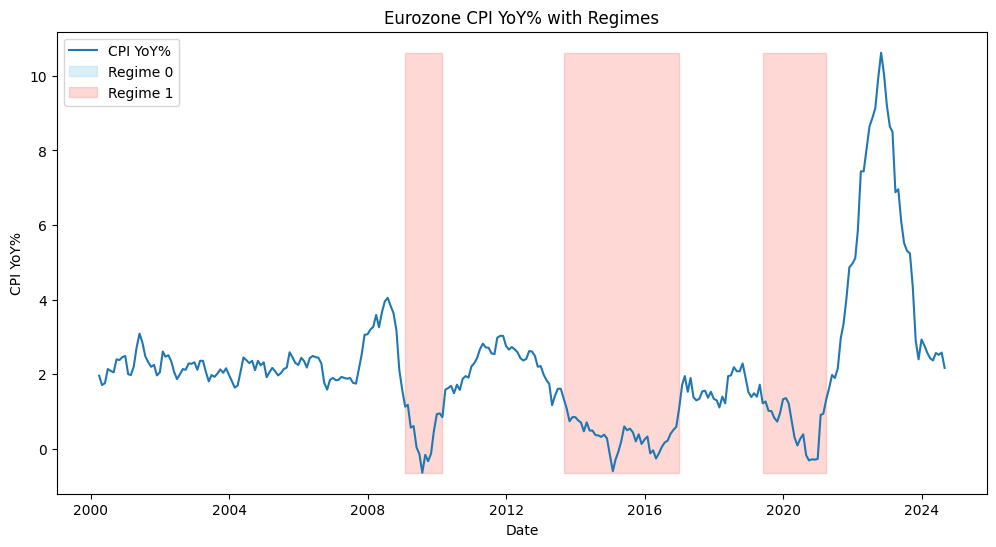

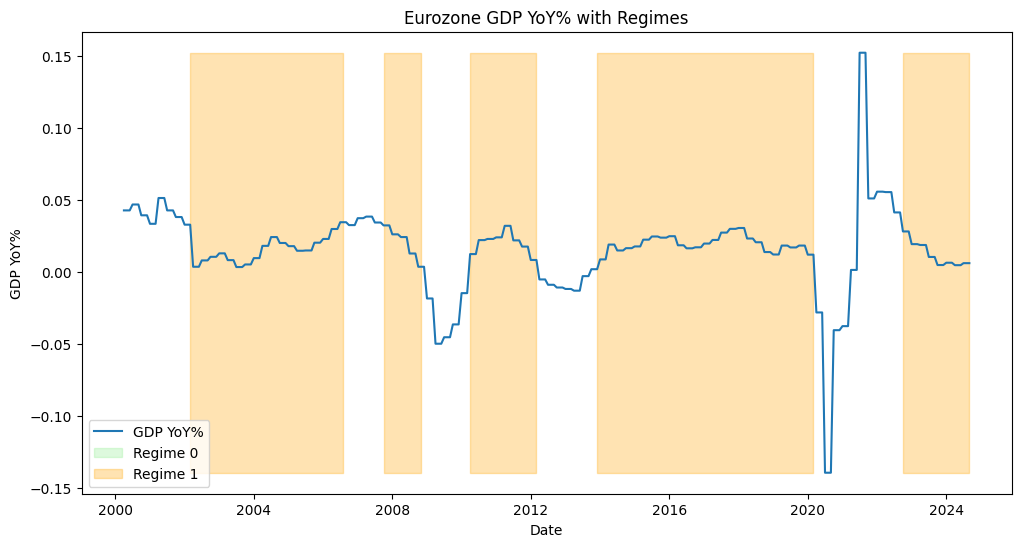

In [66]:
import matplotlib.pyplot as plt

# For CPI Data
plt.figure(figsize=(12, 6))
plt.plot(store["Eurozone"]['Period'], store["Eurozone"]['CPI_YoY%'], label='CPI YoY%')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['CPI_YoY%'].min(), store["Eurozone"]['CPI_YoY%'].max(),
                 where=store["Eurozone"]['Inflation_Regime'] == 0, color='skyblue', alpha=0.3, label='Regime 0')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['CPI_YoY%'].min(), store["Eurozone"]['CPI_YoY%'].max(),
                 where=store["Eurozone"]['Inflation_Regime'] == 1, color='salmon', alpha=0.3, label='Regime 1')
plt.legend()
plt.title('Eurozone CPI YoY% with Regimes')
plt.xlabel('Date')
plt.ylabel('CPI YoY%')
plt.show()

# For GDP Data
plt.figure(figsize=(12, 6))
plt.plot(store["Eurozone"]['Period'], store["Eurozone"]['GDP_YoY%'], label='GDP YoY%')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['GDP_YoY%'].min(), store["Eurozone"]['GDP_YoY%'].max(),
                 where=store["Eurozone"]['Growth_Regime'] == 0, color='lightgreen', alpha=0.3, label='Regime 0')
plt.fill_between(store["Eurozone"]['Period'], 
                 store["Eurozone"]['GDP_YoY%'].min(), store["Eurozone"]['GDP_YoY%'].max(),
                 where=store["Eurozone"]['Growth_Regime'] == 1, color='orange', alpha=0.3, label='Regime 1')
plt.legend()
plt.title('Eurozone GDP YoY% with Regimes')
plt.xlabel('Date')
plt.ylabel('GDP YoY%')
plt.show()

In [67]:
# For Inflation Model
print("Inflation Model Transition Probabilities:")
print(inflation_result.params[["p[0->0]", "p[1->0]"]])

# For Growth Model
print("Growth Model Transition Probabilities:")
print(growth_result.params[["p[0->0]", "p[1->0]"]])

Inflation Model Transition Probabilities:
p[0->0]    0.957223
p[1->0]    0.013092
dtype: float64
Growth Model Transition Probabilities:
p[0->0]    0.974824
p[1->0]    0.043583
dtype: float64


In [68]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# For Inflation Model Residuals
inflation_resid = inflation_result.resid.dropna()

# Autocorrelation Test
lb_stat, lb_pvalue = acorr_ljungbox(inflation_resid, lags=[10], return_df=False)
print('Inflation Residuals Ljung-Box Test p-value:', lb_pvalue)

# Normality Test
stat, p = shapiro(inflation_resid)
print('Inflation Residuals Shapiro-Wilk Test p-value:', p)

# For Growth Model Residuals
growth_resid = growth_result.resid.dropna()

# Autocorrelation Test
lb_stat, lb_pvalue = acorr_ljungbox(growth_resid, lags=[10], return_df=False)
print('Growth Residuals Ljung-Box Test p-value:', lb_pvalue)

# Normality Test
stat, p = shapiro(growth_resid)
print('Growth Residuals Shapiro-Wilk Test p-value:', p)

Inflation Residuals Ljung-Box Test p-value: lb_pvalue
Inflation Residuals Shapiro-Wilk Test p-value: 3.9725970873924375e-25
Growth Residuals Ljung-Box Test p-value: lb_pvalue
Growth Residuals Shapiro-Wilk Test p-value: 2.7525841626080186e-18


In [73]:
store["Eurozone"]

,Period,GDP_YoY%,CPI_YoY%,Low_Inf_Prob,High_Inf_Prob,Inflation_Regime,Low_Growth_Prob,High_Growth_Prob,Growth_Regime,Inflation_Regime_Prob_0,Inflation_Regime_Prob_1,Growth_Regime_Prob_0,Growth_Regime_Prob_1
0,2000-03-31,0.0426,1.96,9.190478e-04,0.999081,2,0.002483,0.997517,2,9.190478e-04,0.999081,0.002483,0.997517
1,2000-04-30,0.0426,1.71,3.237920e-04,0.999676,2,0.000196,0.999804,2,3.237920e-04,0.999676,0.000196,0.999804
2,2000-05-31,0.0426,1.76,1.436687e-04,0.999856,2,0.000073,0.999927,2,1.436687e-04,0.999856,0.000073,0.999927
3,2000-06-30,0.0467,2.14,1.352106e-05,0.999986,2,0.000012,0.999988,2,1.352106e-05,0.999986,0.000012,0.999988
4,2000-07-31,0.0467,2.09,1.542658e-05,0.999985,2,0.000011,0.999989,2,1.542658e-05,0.999985,0.000011,0.999989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2024-04-30,0.0046,2.37,2.229501e-06,0.999998,2,0.994415,0.005585,1,2.229501e-06,0.999998,0.994415,0.005585
290,2024-05-31,0.0046,2.57,4.945879e-07,1.000000,2,0.993032,0.006968,1,4.945879e-07,1.000000,0.993032,0.006968
291,2024-06-30,0.0060,2.52,7.278651e-07,0.999999,2,0.991166,0.008834,1,7.278651e-07,0.999999,0.991166,0.008834
292,2024-07-31,0.0060,2.58,6.106611e-07,0.999999,2,0.986168,0.013832,1,6.106611e-07,0.999999,0.986168,0.013832


In [72]:
filtered_rows = store["Eurozone"][store["Eurozone"]['Growth_Regime'] == 1]

print(filtered_rows.count())

Period                     192
GDP_YoY%                   192
CPI_YoY%                   192
Low_Inf_Prob               192
High_Inf_Prob              192
Inflation_Regime           192
Low_Growth_Prob            192
High_Growth_Prob           192
Growth_Regime              192
Inflation_Regime_Prob_0    192
Inflation_Regime_Prob_1    192
Growth_Regime_Prob_0       192
Growth_Regime_Prob_1       192
dtype: int64


In [74]:
def assign_regime(row):
    if row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 1:
        return 1  # Low Inflation, Low Growth
    elif row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 2:
        return 2  # Low Inflation, High Growth
    elif row['Inflation_Regime'] == 2 and row['Growth_Regime'] == 1:
        return 3  # High Inflation, Low Growth
    else:
        return 4  # High Inflation, High Growth

store["Eurozone"]['Combined_Regime'] = store["Eurozone"].apply(assign_regime, axis=1)


In [79]:
store["Eurozone"]=store["Eurozone"].drop(["Low_Inf_Prob",	"High_Inf_Prob", "Low_Growth_Prob",	"High_Growth_Prob", "Inflation_Regime_Prob_0",	"Inflation_Regime_Prob_1",	"Growth_Regime_Prob_0",	"Growth_Regime_Prob_1","Inflation_Regime",	"Growth_Regime"], axis =1)

In [82]:
store["Eurozone"].to_csv("../Data CSV/EurozoneMarkov", sep=',', index=False, encoding='utf-8')

In [83]:
inflation_model = MarkovRegression(store["Switzerland"]['CPI_YoY%'], k_regimes=2, trend='c', switching_variance=True)
inflation_result = inflation_model.fit()

print("Inflation Model Summary:")
print(inflation_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Switzerland"]['Low_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[0]
store["Switzerland"]['High_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Switzerland"]['Inflation_Regime'] = np.where( store["Switzerland"]['Low_Inf_Prob'] > store["Switzerland"]['High_Inf_Prob'], 1, 2)

growth_model = MarkovRegression(store["Switzerland"]['GDP_YoY%'], k_regimes=2, trend='c', switching_variance=True)
growth_result = growth_model.fit()

print("Growth Model Summary:")
print(growth_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["Switzerland"]['Low_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[0]
store["Switzerland"]['High_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["Switzerland"]['Growth_Regime'] = np.where( store["Switzerland"]['Low_Growth_Prob'] > store["Switzerland"]['High_Growth_Prob'], 1, 2)
# Extract smoothed probabilities
inflation_smoothed_probs = inflation_result.smoothed_marginal_probabilities
growth_smoothed_probs = growth_result.smoothed_marginal_probabilities

# Add to DataFrame
store["Switzerland"]['Inflation_Regime_Prob_0'] = inflation_smoothed_probs[0]
store["Switzerland"]['Inflation_Regime_Prob_1'] = inflation_smoothed_probs[1]

store["Switzerland"]['Growth_Regime_Prob_0'] = growth_smoothed_probs[0]
store["Switzerland"]['Growth_Regime_Prob_1'] = growth_smoothed_probs[1]

def assign_regime(row):
    if row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 1:
        return 1  # Low Inflation, Low Growth
    elif row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 2:
        return 2  # Low Inflation, High Growth
    elif row['Inflation_Regime'] == 2 and row['Growth_Regime'] == 1:
        return 3  # High Inflation, Low Growth
    else:
        return 4  # High Inflation, High Growth

store["Switzerland"]['Combined_Regime'] = store["Switzerland"].apply(assign_regime, axis=1)
store["Switzerland"]=store["Switzerland"].drop(["Low_Inf_Prob",	"High_Inf_Prob", "Low_Growth_Prob",	"High_Growth_Prob", "Inflation_Regime_Prob_0",	"Inflation_Regime_Prob_1",	"Growth_Regime_Prob_0",	"Growth_Regime_Prob_1","Inflation_Regime",	"Growth_Regime"], axis =1)

store["Switzerland"].to_csv("../Data CSV/SwitzerlandMarkov", sep=',', index=False, encoding='utf-8')

Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -359.448
Date:                Sun, 10 Nov 2024   AIC                            730.896
Time:                        00:39:54   BIC                            752.998
Sample:                             0   HQIC                           739.747
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8667      0.042     20.510      0.000       0.784       0.950
sigma2         0.2138      

In [84]:
inflation_model = MarkovRegression(store["USA"]['CPI_YoY%'], k_regimes=2, trend='c', switching_variance=True)
inflation_result = inflation_model.fit()

print("Inflation Model Summary:")
print(inflation_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["USA"]['Low_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[0]
store["USA"]['High_Inf_Prob'] = inflation_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["USA"]['Inflation_Regime'] = np.where( store["USA"]['Low_Inf_Prob'] > store["USA"]['High_Inf_Prob'], 1, 2)

growth_model = MarkovRegression(store["USA"]['GDP_YoY%'], k_regimes=2, trend='c', switching_variance=True)
growth_result = growth_model.fit()

print("Growth Model Summary:")
print(growth_result.summary())

# Step 3: Extract Inflation Regime Probabilities
store["USA"]['Low_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[0]
store["USA"]['High_Growth_Prob'] = growth_result.smoothed_marginal_probabilities[1]

# Assign Inflation Regimes based on higher probability
store["USA"]['Growth_Regime'] = np.where( store["USA"]['Low_Growth_Prob'] > store["USA"]['High_Growth_Prob'], 1, 2)
# Extract smoothed probabilities
inflation_smoothed_probs = inflation_result.smoothed_marginal_probabilities
growth_smoothed_probs = growth_result.smoothed_marginal_probabilities

# Add to DataFrame
store["USA"]['Inflation_Regime_Prob_0'] = inflation_smoothed_probs[0]
store["USA"]['Inflation_Regime_Prob_1'] = inflation_smoothed_probs[1]

store["USA"]['Growth_Regime_Prob_0'] = growth_smoothed_probs[0]
store["USA"]['Growth_Regime_Prob_1'] = growth_smoothed_probs[1]

def assign_regime(row):
    if row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 1:
        return 1  # Low Inflation, Low Growth
    elif row['Inflation_Regime'] == 1 and row['Growth_Regime'] == 2:
        return 2  # Low Inflation, High Growth
    elif row['Inflation_Regime'] == 2 and row['Growth_Regime'] == 1:
        return 3  # High Inflation, Low Growth
    else:
        return 4  # High Inflation, High Growth

store["USA"]['Combined_Regime'] = store["USA"].apply(assign_regime, axis=1)
store["USA"]=store["USA"].drop(["Low_Inf_Prob",	"High_Inf_Prob", "Low_Growth_Prob",	"High_Growth_Prob", "Inflation_Regime_Prob_0",	"Inflation_Regime_Prob_1",	"Growth_Regime_Prob_0",	"Growth_Regime_Prob_1","Inflation_Regime",	"Growth_Regime"], axis =1)

store["USA"].to_csv("../Data CSV/USAMarkov", sep=',', index=False, encoding='utf-8')

Inflation Model Summary:
                        Markov Switching Model Results                        
Dep. Variable:               CPI_YoY%   No. Observations:                  294
Model:               MarkovRegression   Log Likelihood                -482.744
Date:                Sun, 10 Nov 2024   AIC                            977.488
Time:                        00:40:27   BIC                            999.590
Sample:                             0   HQIC                           986.339
                                - 294                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5968      0.079     20.340      0.000       1.443       1.751
sigma2         0.8823      